In [9]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

import random
random.seed(1000)

In [10]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\bhoom\AppData\Local\Temp/ipykernel_8420/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [11]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [12]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [13]:
df1 = pd.read_csv("SRER_2017_training_bi.csv", na_values = '?').dropna()
df1['year'] = 2017
df2 = pd.read_csv("SRER21_dataset_v1.csv", na_values = '?').dropna()
df2['year'] = 2021
frames = [df1, df2]
df = pd.concat(frames)
df = df.reindex(columns=['OID_', 'Id', 'gridcode', 'Shape_Length', 'Shape_Area', 'CH_mean', 'ARVI_mean', 'ARVI_med', 'ARVI_max', 'EVI_mean', 'EVI_med', 'EVI_max', 'NDVI_mean', 'NDVI_med', 'NDVI_max', 'SAVI_mean', 'SAVI_med', 'SAVI_max', 'year', 'Veg_class'])
df


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,year,Veg_class
0,2,2,2,20.4,2.38,1.000000,0.273945,0.273945,0.273945,0.323257,0.323257,0.323257,0.428208,0.428208,0.428208,0.311936,0.311936,0.311936,2017,woody
1,3,3,3,8.2,1.32,1.000000,0.530157,0.530157,0.530157,0.460513,0.460513,0.460513,0.611745,0.611745,0.611745,0.416492,0.416492,0.416492,2017,woody
2,4,4,4,55.8,24.43,0.920000,0.477979,0.501013,0.616707,0.381095,0.384718,0.447304,0.576437,0.596638,0.673767,0.359786,0.364317,0.414173,2017,woody
3,5,5,5,15.2,1.88,1.000000,0.342944,0.342944,0.342944,0.346714,0.346714,0.346714,0.468738,0.468738,0.468738,0.323907,0.323907,0.323907,2017,woody
4,6,6,6,27.2,9.29,0.142857,0.044382,-0.008903,0.265536,0.181714,0.147391,0.315684,0.223522,0.178629,0.412030,0.177739,0.147325,0.299311,2017,non-woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,7761,7761,7761,12.0,1.59,0.666667,0.536690,0.552596,0.568966,0.378935,0.397165,0.403695,0.615736,0.627957,0.640278,0.358073,0.373771,0.377543,2021,woody
7760,7762,7762,7762,14.6,3.20,1.000000,0.482610,0.482610,0.483734,0.322043,0.322043,0.324235,0.576554,0.576554,0.577511,0.312786,0.312786,0.314608,2021,woody
7761,7763,7763,7763,10.6,2.24,0.500000,0.446487,0.446487,0.517261,0.364414,0.364414,0.412901,0.559486,0.559486,0.608110,0.348984,0.348984,0.386288,2021,woody
7764,7766,7766,7766,16.2,3.62,0.666667,0.578637,0.594556,0.623445,0.268822,0.271254,0.306740,0.614486,0.620037,0.654546,0.262576,0.265154,0.296495,2021,woody


In [14]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(df): 
    
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.3393933000006655 seconds ---

Accuracy of each fold: 
 [0.8445995591476855, 0.8361498897869214, 0.8486407053637032, 0.8445995591476855, 0.834313005143277]
Avg accuracy: 0.8416605437178545
Std of accuracy : 
0.0054836467765011785

[[3468  992]
 [1163 7987]]

              precision    recall  f1-score   support

   non-woody       0.75      0.78      0.76      4460
       woody       0.89      0.87      0.88      9150

    accuracy                           0.84     13610
   macro avg       0.82      0.83      0.82     13610
weighted avg       0.84      0.84      0.84     13610

0.7775784753363228
0.872896174863388
0.7488663355646729
0.7629523704762953


In [15]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 1.3389000999995915 seconds ---
55.27649738370235


In [16]:
awoodyarea4 = 0
anonwoodyarea4 = 0
atotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,1):
            for l in testindex9[k]:
                if l == "woody":
                    awoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC4 = awoodyarea4/atotalarea4 * 100
                    
print(aFWC4)

---Run time is 1180.1474291000013 seconds ---
65.94415870803121


In [17]:
bwoodyarea4 = 0
bnonwoodyarea4 = 0
btotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(1,2):
            for l in testindex9[k]:
                if l == "woody":
                    bwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC4 = bwoodyarea4/btotalarea4 * 100
                    
print(bFWC4)

---Run time is 1211.9881590000005 seconds ---
64.40117560731657


In [18]:
cwoodyarea4 = 0
cnonwoodyarea4 = 0
ctotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(2,3):
            for l in testindex9[k]:
                if l == "woody":
                    cwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC4 = cwoodyarea4/ctotalarea4 * 100
                    
print(cFWC4)

---Run time is 1153.3492907000036 seconds ---
67.26671565148382


In [19]:
dwoodyarea4 = 0
dnonwoodyarea4 = 0
dtotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(3,4):
            for l in testindex9[k]:
                if l == "woody":
                    dwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC4 = dwoodyarea4/dtotalarea4 * 100
                    
print(dFWC4)

---Run time is 1112.6338515000025 seconds ---
66.7523879512523


In [20]:
ewoodyarea4 = 0
enonwoodyarea4 = 0
etotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(4,5):
            for l in testindex9[k]:
                if l == "woody":
                    ewoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC4 = ewoodyarea4/etotalarea4 * 100
                    
print(eFWC4)

---Run time is 18888.969299900004 seconds ---
65.50330639351934


In [22]:
tFWC4 = (aFWC4 +bFWC4 +cFWC4 +dFWC4 +eFWC4) / 5
print(tFWC4)

65.97354886232065


In [23]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
  
for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 18918.428288300005 seconds ---

Accuracy of each fold: 
 [0.8519470977222631, 0.8526818515797208, 0.8677443056576047, 0.8633357825128581, 0.8519470977222631]
Avg accuracy: 0.8575312270389419
Std of accuracy : 
0.006691506286570152

[[3586  874]
 [1065 8085]]

              precision    recall  f1-score   support

   non-woody       0.77      0.80      0.79      4460
       woody       0.90      0.88      0.89      9150

    accuracy                           0.86     13610
   macro avg       0.84      0.84      0.84     13610
weighted avg       0.86      0.86      0.86     13610

0.8040358744394619
0.8836065573770492
0.7710169855944958
0.7871803314674569


In [24]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.8022883000012371 seconds ---
55.27649738370235
55.27649738370235


In [25]:
awoodyarea1 = 0
anonwoodyarea1 = 0
atotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,1):
            for l in testindex2[k]:
                if l == "woody":
                    awoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC = awoodyarea1/atotalarea1 * 100
                    
print(aFWC)

---Run time is 1112.0531257000039 seconds ---
66.8993387227245


In [26]:
bwoodyarea1 = 0
bnonwoodyarea1 = 0
btotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(1,2):
            for l in testindex2[k]:
                if l == "woody":
                    bwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC = bwoodyarea1/btotalarea1 * 100
                    
print(bFWC)

---Run time is 1124.6202827000016 seconds ---
64.14401175719192


In [27]:
cwoodyarea1 = 0
cnonwoodyarea1 = 0
ctotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(2,3):
            for l in testindex2[k]:
                if l == "woody":
                    cwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC = cwoodyarea1/ctotalarea1 * 100
                    
print(cFWC)

---Run time is 1123.1650863000032 seconds ---
66.82586333700023


In [28]:
dwoodyarea1 = 0
dnonwoodyarea1 = 0
dtotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(3,4):
            for l in testindex2[k]:
                if l == "woody":
                    dwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC = dwoodyarea1/dtotalarea1 * 100
                    
print(dFWC)

---Run time is 1241.633183900005 seconds ---
65.98089640090717


In [29]:
ewoodyarea1 = 0
enonwoodyarea1 = 0
etotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(4,5):
            for l in testindex2[k]:
                if l == "woody":
                    ewoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC = ewoodyarea1/etotalarea1 * 100
                    
print(eFWC)

---Run time is 1260.743975999998 seconds ---
65.28288023626723


In [30]:
tFWC = (aFWC + bFWC + cFWC + dFWC + eFWC) / 5
print(tFWC)

65.8265980908182


In [31]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []


for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 1385.9085722999953 seconds ---

Accuracy of each fold: 
 [0.8199853049228508, 0.8258633357825128, 0.8291697281410727, 0.8398236590742102, 0.8295371050698016]
Avg accuracy: 0.8288758265980898
Std of accuracy : 
0.006457479072070516

[[3641  819]
 [1510 7640]]

              precision    recall  f1-score   support

   non-woody       0.71      0.82      0.76      4460
       woody       0.90      0.83      0.87      9150

    accuracy                           0.83     13610
   macro avg       0.81      0.83      0.81     13610
weighted avg       0.84      0.83      0.83     13610

0.8163677130044843
0.8349726775956284
0.706853038245001
0.7576734991155968


In [32]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 1.4125477999987197 seconds ---
55.27649738370235


In [34]:
awoodyarea2 = 0
anonwoodyarea2 = 0
atotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,1):
            for l in testindex4[k]:
                if l == "woody":
                    awoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC2 = awoodyarea2/atotalarea2 * 100
                    
print(aFWC2)

---Run time is 1645.4217424000017 seconds ---
62.601028656482285


In [35]:
bwoodyarea2 = 0
bnonwoodyarea2 = 0
btotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(1,2):
            for l in testindex4[k]:
                if l == "woody":
                    bwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC2 = bwoodyarea2/btotalarea2 * 100
                    
print(bFWC2)

---Run time is 3048.140393300004 seconds ---
61.09478324866363


In [36]:
cwoodyarea2 = 0
cnonwoodyarea2 = 0
ctotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(2,3):
            for l in testindex4[k]:
                if l == "woody":
                    cwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC2 = cwoodyarea2/ctotalarea2 * 100
                    
print(cFWC2)

---Run time is 1099.0848001999984 seconds ---
62.08670095625006


In [40]:
dwoodyarea2 = 0
dnonwoodyarea2 = 0
dtotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(3,4):
            for l in testindex4[k]:
                if l == "woody":
                    dwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC2 = dwoodyarea2/dtotalarea2 * 100
                    
print(dFWC2)

---Run time is 1133.8351408000017 seconds ---
63.188831742483046


In [41]:
ewoodyarea2 = 0
enonwoodyarea2 = 0
etotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(4,5):
            for l in testindex4[k]:
                if l == "woody":
                    ewoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC2 = ewoodyarea2/etotalarea2 * 100
                    
print(eFWC2)

---Run time is 1124.5870521000033 seconds ---
61.79279941332758


In [42]:
tFWC2 = (aFWC2 + bFWC2 + cFWC2 + dFWC2 + eFWC2) / 5

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [43]:
KNN_result = []
X=df.iloc[:, 5:19]
Y=df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.80822924 0.79647318 0.82916973 0.81300514 0.81447465]

Avg accuracy: 0.8122703894195444

K=2

Accuracy of each fold: 
 [0.80859662 0.79831007 0.81337252 0.81300514 0.80933137]

Avg accuracy: 0.80852314474651

K=3

Accuracy of each fold: 
 [0.83394563 0.82145481 0.84496694 0.83835415 0.82696547]

Avg accuracy: 0.8331373989713446

K=4

Accuracy of each fold: 
 [0.83247612 0.82402645 0.85047759 0.8328435  0.82623071]

Avg accuracy: 0.8332108743570904

K=5

Accuracy of each fold: 
 [0.84386481 0.82696547 0.85892726 0.84386481 0.83982366]

Avg accuracy: 0.8426891991182954

K=6

Accuracy of each fold: 
 [0.83982366 0.83137399 0.85892726 0.83945628 0.83210874]

Avg accuracy: 0.8403379867744306

K=7

Accuracy of each fold: 
 [0.85231447 0.83872153 0.86223365 0.85231447 0.83945628]

Avg accuracy: 0.8490080822924322

K=8

Accuracy of each fold: 
 [0.84937546 0.83504776 0.85855988 0.85157972 0.83908891]

Avg accuracy: 0.8467303453343129

K=9

Accuracy of each fold

In [44]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 1133.5373429000028 seconds ---

Accuracy of each fold: 
 [0.8519470977222631, 0.8379867744305658, 0.8644379132990448, 0.8570903747244673, 0.8442321822189567]
Avg accuracy: 0.8511388684790596
Std of accuracy : 
0.009312552251435614

[[3428 1032]
 [ 994 8156]]

              precision    recall  f1-score   support

   non-woody       0.78      0.77      0.77      4460
       woody       0.89      0.89      0.89      9150

    accuracy                           0.85     13610
   macro avg       0.83      0.83      0.83     13610
weighted avg       0.85      0.85      0.85     13610

0.768609865470852
0.8913661202185792
0.7752148349163275
0.7718982211213691


In [45]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.8200413000013214 seconds ---
55.27649738370235


In [46]:
awoodyarea3 = 0
anonwoodyarea3 = 0
atotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,1):
            for l in testindex6[k]:
                if l == "woody":
                    awoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC3 = awoodyarea3/atotalarea3 * 100
                    
print(aFWC3)

---Run time is 1114.9500704999955 seconds ---
67.4136664230039


In [47]:
bwoodyarea3 = 0
bnonwoodyarea3 = 0
btotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(1,2):
            for l in testindex6[k]:
                if l == "woody":
                    bwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC3 = bwoodyarea3/btotalarea3 * 100
                    
print(bFWC3)

---Run time is 1108.1490711000079 seconds ---
66.71565025838608


In [48]:
cwoodyarea3 = 0
cnonwoodyarea3 = 0
ctotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(2,3):
            for l in testindex6[k]:
                if l == "woody":
                    cwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC3 = cwoodyarea3/ctotalarea3 * 100
                    
print(cFWC3)

---Run time is 1116.0839154999994 seconds ---
68.1116825875423


In [49]:
dwoodyarea3 = 0
dnonwoodyarea3 = 0
dtotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(3,4):
            for l in testindex6[k]:
                if l == "woody":
                    dwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC3 = dwoodyarea3/dtotalarea3 * 100
                    
print(dFWC3)

---Run time is 1123.6150991999893 seconds ---
67.92799412317368


In [50]:
ewoodyarea3 = 0
enonwoodyarea3 = 0
etotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(4,5):
            for l in testindex6[k]:
                if l == "woody":
                    ewoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC3 = ewoodyarea3/etotalarea3 * 100
                    
print(eFWC3)

---Run time is 1112.5979348999972 seconds ---
67.3769287301218


In [51]:
tFWC3 = (aFWC3 + bFWC3 + cFWC3 + dFWC3 + eFWC3) / 5

In [52]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.841661,0.005484,0.777578,0.872896,0.748866,0.762952,0.339393
LDA,0.857531,0.006692,0.804036,0.883607,0.771017,0.787180,18918.428288
QDA,0.828876,0.006457,0.816368,0.834973,0.706853,0.757673,1385.908572
KNN-CV,0.851139,0.009313,0.768610,0.891366,0.775215,0.771898,1133.537343


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.8416605437178545, 0.8575312270389419, 0.8288758265980898, 0.8511388684790596]
Sen[0.7775784753363228, 0.8040358744394619, 0.8163677130044843, 0.768609865470852]
Spec[0.872896174863388, 0.8836065573770492, 0.8349726775956284, 0.8913661202185792]
P[0.7488663355646729, 0.7710169855944958, 0.706853038245001, 0.7752148349163275]
F1[0.7629523704762953, 0.7871803314674569, 0.7576734991155968, 0.7718982211213691]


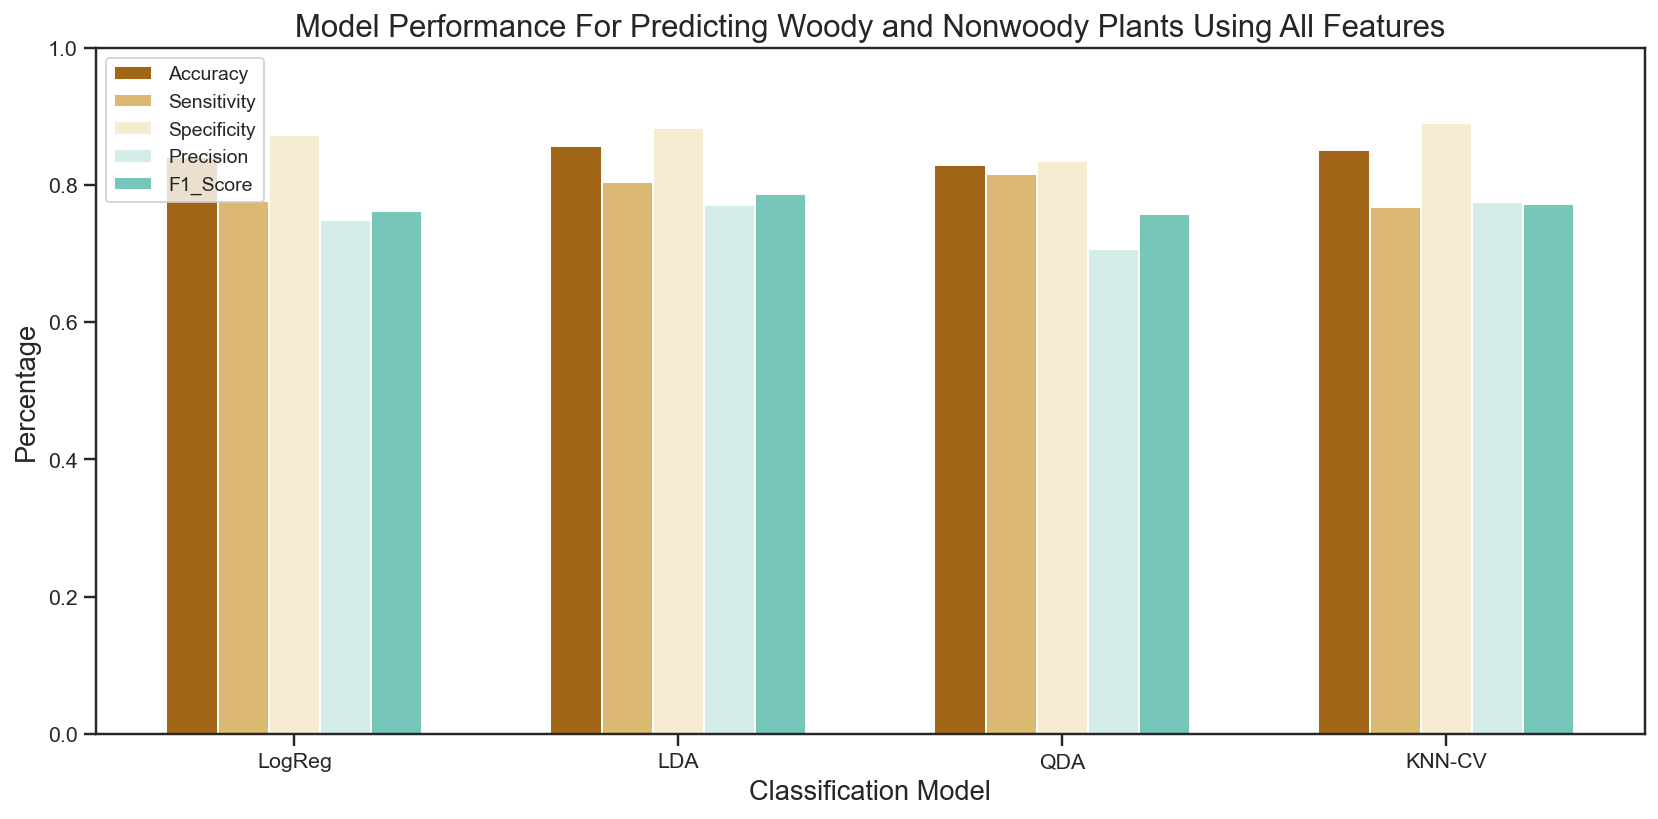

In [53]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

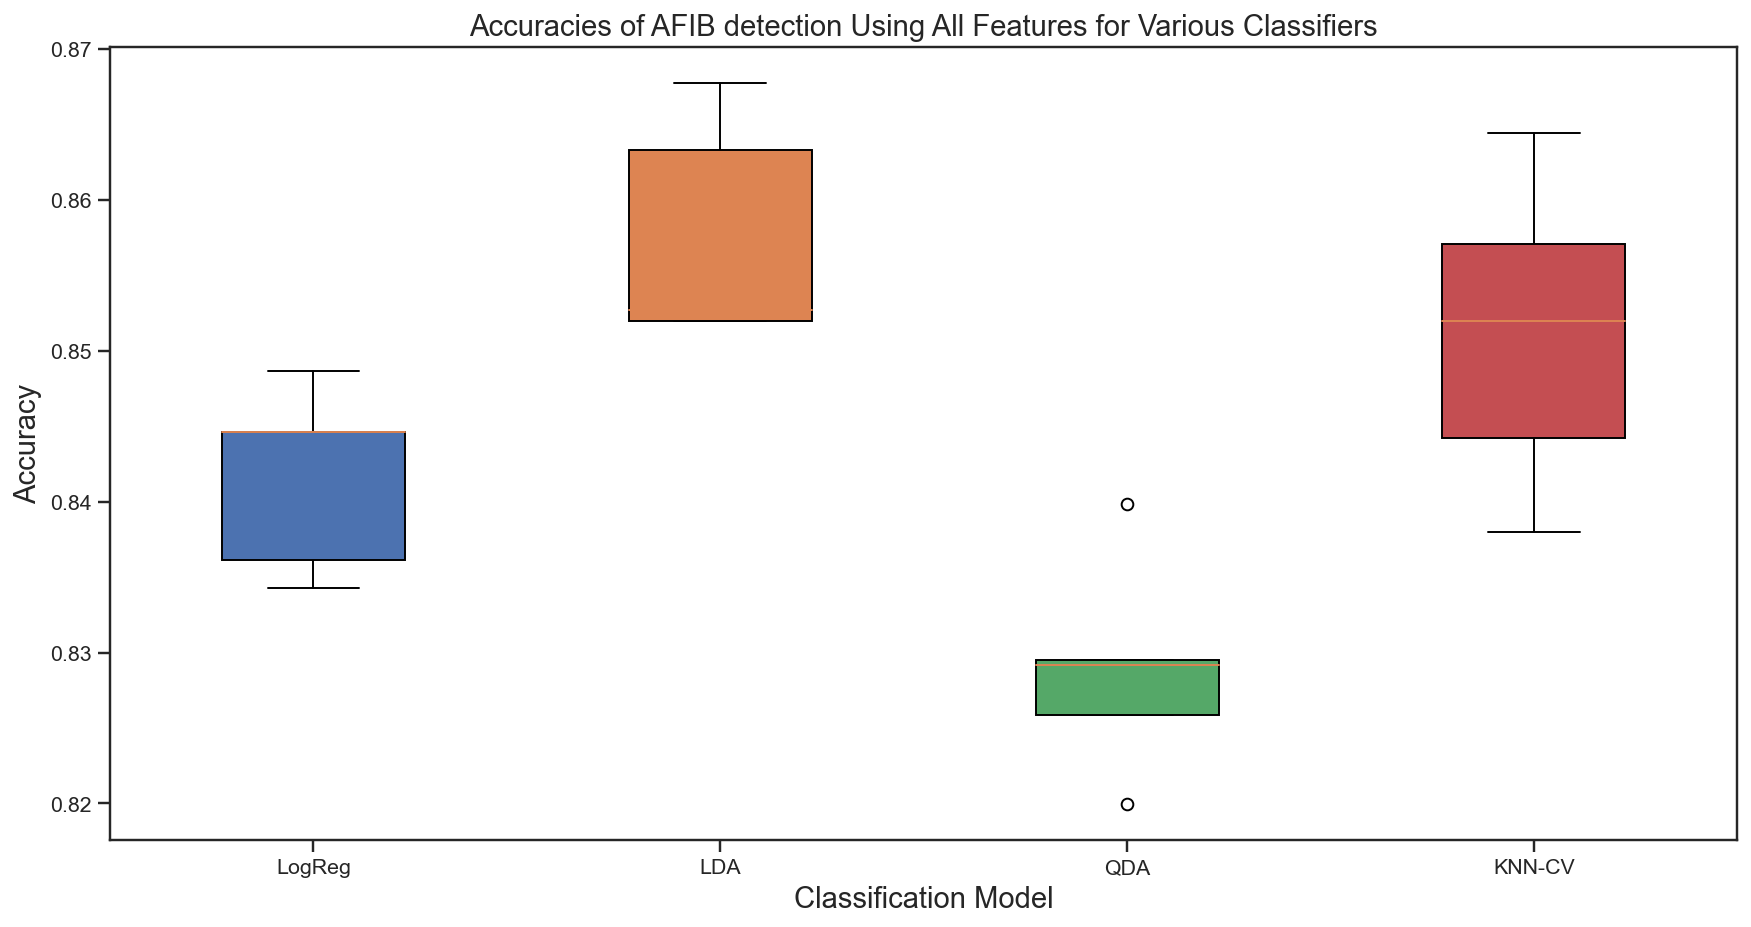

In [54]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [55]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(tFWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(tFWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(tFWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(tFWC3))

Log reg act: 55.27649738370235
Log reg pred: 65.97354886232065
QDA act: 55.27649738370235
QDA pred: 62.152828803441324
LDA act: 55.27649738370235
LDA pred: 65.8265980908182
KNN act: 55.27649738370235
KNN pred: 67.50918442444555
